In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Notes
 * Accuracy isn't good metric with imbalanced data(class-imbalance), when we have (20% of 0 and 80% of 1 fe)
 * Precision is fraction of positive predictions are correct
 * 1-Precision tells us how many users we identify incorrectly (who not going to 1, they are 0, but we say they are 1)
 * Recall is fraction of correctly identified positive examples
 * 1-Recall tells us how many users in % we failed to identify(who are going to 1, but we say they 0)
 
 * AUC tells us the probability is randomly selected positive 1 example has higher score than negative 0 P(1r > 0r)=AUC

## Get the data

In [2]:
df = pd.read_csv("AER_credit_card_data.csv")

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Data preparation

- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [4]:
df["card"] = df["card"].map({'yes': 1, 'no': 0})

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_full_train, df_test = train_test_split(df, test_size=.2, random_state=1)

In [7]:
df_train, df_val = train_test_split(
    df_full_train, test_size=.25, random_state=1)

In [8]:
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

In [9]:
y_train, y_val, y_test = df_train['card'], df_val['card'], df_test['card']
for df_ in [df_train, df_val, df_test]:
    del df_['card']  

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [11]:
numerical_vars = list(df_train[df_train.columns.difference(["card"])].select_dtypes(include=np.number).columns)

In [12]:
aucs = dict()
for var in numerical_vars:
    auc_ = roc_auc_score(y_train, df_train[var])
    if auc_ < 0.5:
        auc_ = roc_auc_score(y_train, -df_train[var])
    aucs[var] = auc_    

In [13]:
sorted(aucs.items(), key=lambda x: x[1])

[('age', 0.5240020979407055),
 ('months', 0.5294217780967629),
 ('dependents', 0.5327757227773791),
 ('majorcards', 0.5343859842838476),
 ('income', 0.5908049467233478),
 ('active', 0.6043173411362006),
 ('reports', 0.7166629860689376),
 ('share', 0.989183643423692),
 ('expenditure', 0.991042345276873)]

### Answer = 'share'

## Training the model

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [15]:
for df_ in [df_train, df_val, df_test]:
    df_ = df[["reports", "age", "income", "share", "expenditure",
             "dependents", "months", "majorcards", "active", "owner", "selfemp"]]

### One-hot encoding

In [16]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [17]:
# sparse - is a matrix that is comprised of mostly zero values.
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [18]:
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [19]:
dv.get_feature_names()

['active',
 'age',
 'dependents',
 'expenditure',
 'income',
 'majorcards',
 'months',
 'owner=no',
 'owner=yes',
 'reports',
 'selfemp=no',
 'selfemp=yes',
 'share']

### Training the model

In [20]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
y_pred_bin = model.predict(X_val)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [21]:
roc_auc_score(y_val, y_pred)

0.995171242063847

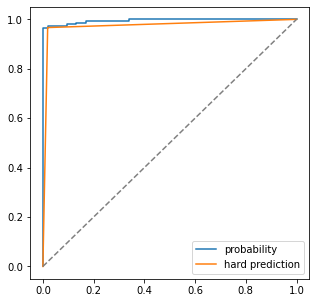

In [22]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Answer = 0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

### Create a confusion matrix

In [23]:
thresholds = np.linspace(0, 1, 101)

In [24]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        tpr = tp/(tp + fn)
        fpr = fp/(fp + tn)
        scores.append((t, tp, fp, fn, tn, tpr, fpr))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'tpr', 'fpr']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [25]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,211,53,0,0,1.0,1.000000
1,0.01,211,34,0,19,1.0,0.641509
2,0.02,211,31,0,22,1.0,0.584906
3,0.03,211,24,0,29,1.0,0.452830
4,0.04,211,22,0,31,1.0,0.415094


In [26]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

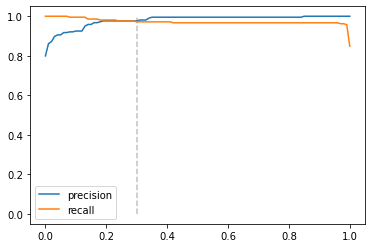

In [27]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

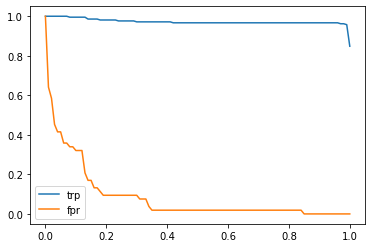

In [28]:
plt.plot(df_scores.threshold, df_scores.tpr, label='trp')
plt.plot(df_scores.threshold, df_scores.fpr, label='fpr')
plt.legend()
plt.show()

### Answer = 0.3

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [29]:
df_scores["f1"] = 2 * df_scores["precision"] * \
    df_scores["recall"] / (df_scores["precision"]+df_scores["recall"])

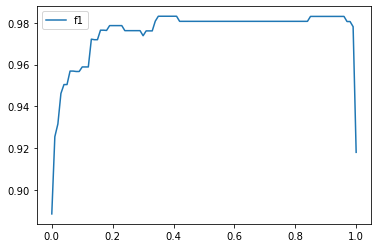

In [30]:
plt.plot(thresholds, df_scores.f1, label='f1')

plt.legend()
plt.show()

In [31]:
df_scores.iloc[df_scores["f1"].idxmax()]

threshold      0.350000
tp           205.000000
fp             1.000000
fn             6.000000
tn            52.000000
tpr            0.971564
fpr            0.018868
precision      0.995146
recall         0.971564
f1             0.983213
Name: 35, dtype: float64

### Answer = 0.4

### AUC

In [32]:
auc(df_scores.fpr, df_scores.tpr)

0.9949923991773227

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

In [33]:
from sklearn.model_selection import KFold

In [34]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[["reports", "age", "income", "share", "expenditure",
             "dependents", "months", "majorcards", "active", "owner", "selfemp"]].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[["reports", "age", "income", "share", "expenditure",
             "dependents", "months", "majorcards", "active", "owner", "selfemp"]].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [35]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idxs, val_idxs in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idxs]
    df_val = df_full_train.iloc[val_idxs]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


### Answer = 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

If you have ties, select the score with the lowest std. If you still have ties, select the smallest Compute

In [36]:
for C in [0.01, 0.1, 1, 10]:   
    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idxs, val_idxs in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idxs]
        df_val = df_full_train.iloc[val_idxs]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(C, '%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.01 0.992 +- 0.006
0.1 0.995 +- 0.004
1 0.996 +- 0.003
10 0.996 +- 0.003


### Answer = 1

## The Sandbox

### Random model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [38]:
((y_rand >= 0.5) == y_val).mean()

0.47393364928909953

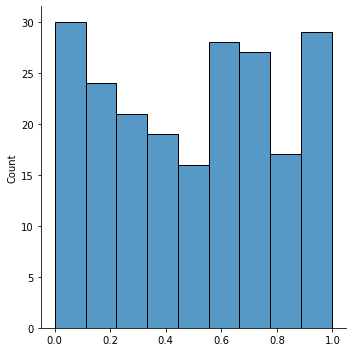

In [39]:
sns.displot(x=y_rand)

In [40]:
df_rand = confusion_matrix_dataframe(y_val, y_rand)

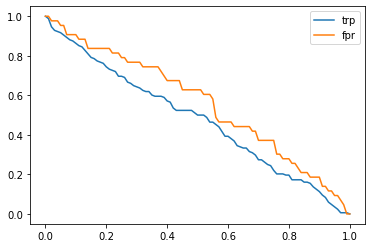

In [41]:
plt.plot(df_rand.threshold, df_rand.tpr, label='trp')
plt.plot(df_rand.threshold, df_rand.fpr, label='fpr')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import roc_curve

In [43]:
fpr, tpr, thresholds = roc_curve(y_val, y_rand)

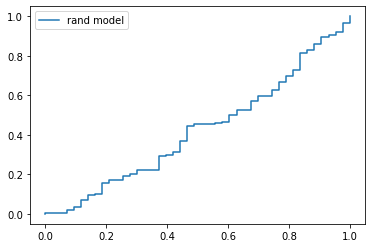

In [44]:
plt.plot(fpr, tpr, label='rand model')
plt.legend()
plt.show()

### Ideal model (Benchmark)

It's not good, cause on train dataset it will be perfect, but on the test it'll show the real number

In [45]:
y_ideal = np.repeat([0, 1], [(y_val == 0).sum(), (y_val == 1).sum()])

In [46]:
(y_val == 0).sum()/((y_val == 0).sum()+(y_val == 1).sum())

0.2037914691943128

In [47]:
1 - y_val.mean()

0.2037914691943128

In [48]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred[::10]

array([0.        , 0.04761905, 0.0952381 , 0.14285714, 0.19047619,
       0.23809524, 0.28571429, 0.33333333, 0.38095238, 0.42857143,
       0.47619048, 0.52380952, 0.57142857, 0.61904762, 0.66666667,
       0.71428571, 0.76190476, 0.80952381, 0.85714286, 0.9047619 ,
       0.95238095, 1.        ])

In [49]:
((y_ideal_pred >=0.20075) == y_ideal).mean()

1.0

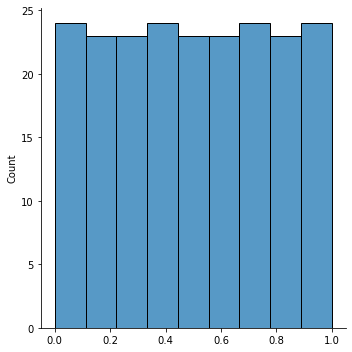

In [50]:
sns.displot(x=y_ideal_pred)

In [51]:
df_ideal = confusion_matrix_dataframe(y_ideal, y_ideal_pred)

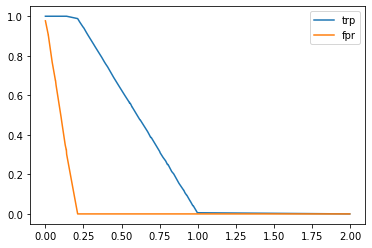

In [52]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='trp')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='fpr')
plt.legend()
plt.show()

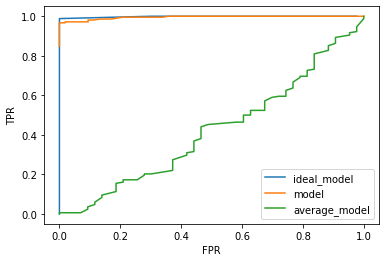

In [53]:
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal_model')
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='average_model')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

With probability of 40% for the customer is 1 it predicts it 1 and with 60% it's not churning

### AUC interpretation

In [54]:
nulls = y_pred[y_val == 0]
ones = y_pred[y_val == 1]

In [55]:
results = []
for i in range(0, 10000, 1):
    null_idx = np.random.randint(0, len(nulls) - 1)
    one_idx = np.random.randint(0, len(ones) - 1)
    results.append(ones[one_idx] > nulls[null_idx])
sum(results)/len(results)

1.0